# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`. This is the dataset to use for this assignment. Note: The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Ann Arbor, Michigan, United States**, and the stations the data comes from are shown on the map below.

In [1]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

leaflet_plot_stations(400,'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89')

In [2]:
#datafile being assigned - data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv

In [3]:
df = pd.read_csv("data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv")

From the discussion thread, we should

Map all days to "day in the year", so January 1 is mapped to 1, and Dec 31 is mapped to 365 for non-leap years and to 366 for leap years.

For leap years drop records with all "day of the year" equal to 60.

For leap years subtract 1 from all "day of the year" that are larger than 60.

In [4]:
df["Date"] = pd.to_datetime(df["Date"])

df['day_of_year']=df['Date'].dt.dayofyear

In [5]:
#Map all days to "day in the year
import calendar
df["is_leap"] = df["Date"].apply(lambda x: calendar.isleap(x.year))

In [6]:
#drop february 29 if isleap
df = df.drop(df[(df.is_leap) & (df.day_of_year == 60)].index)

In [7]:
#For leap years subtract 1 from all "day of the year" that are larger than 60.
df.loc[(df.is_leap) & (df.day_of_year > 60), "day_of_year"] = df.loc[(df.is_leap) & (df.day_of_year > 60)]["day_of_year"] - 1

In [8]:
#Convert tenth of degree to degree
df["Data_Value"] = df["Data_Value"] / 10

In [9]:
#2005-2014
dg = df.loc[df.Date.dt.year.between(2005, 2014)]

In [10]:
#Get max and min temp by day of year
max_temp = dg.groupby("day_of_year")["Data_Value"].max().reset_index()
min_temp = dg.groupby("day_of_year")["Data_Value"].min().reset_index()

In [11]:
dh = df.loc[df.Date.dt.year == 2015]

In [12]:
max_temp_2015 = dh.groupby("day_of_year")["Data_Value"].max().reset_index()
min_temp_2015 = dh.groupby("day_of_year")["Data_Value"].min().reset_index()

In [13]:
max_temp_2015.columns = ["day_of_year", "Data_Value_2015"]
min_temp_2015.columns = ["day_of_year", "Data_Value_2015"]

In [14]:
max_merged = pd.merge(max_temp_2015, max_temp, on="day_of_year", how="inner")
min_merged = pd.merge(min_temp_2015, min_temp, on="day_of_year", how="inner")

In [15]:
max_merged["has_exceed"] = max_merged["Data_Value_2015"] > max_merged["Data_Value"]
min_merged["has_exceed"] = min_merged["Data_Value_2015"] < min_merged["Data_Value"]

exceed_max = max_merged.loc[max_merged.has_exceed]
exceed_min = min_merged.loc[min_merged.has_exceed]

In [16]:
%matplotlib notebook

<IPython.core.display.Javascript object>


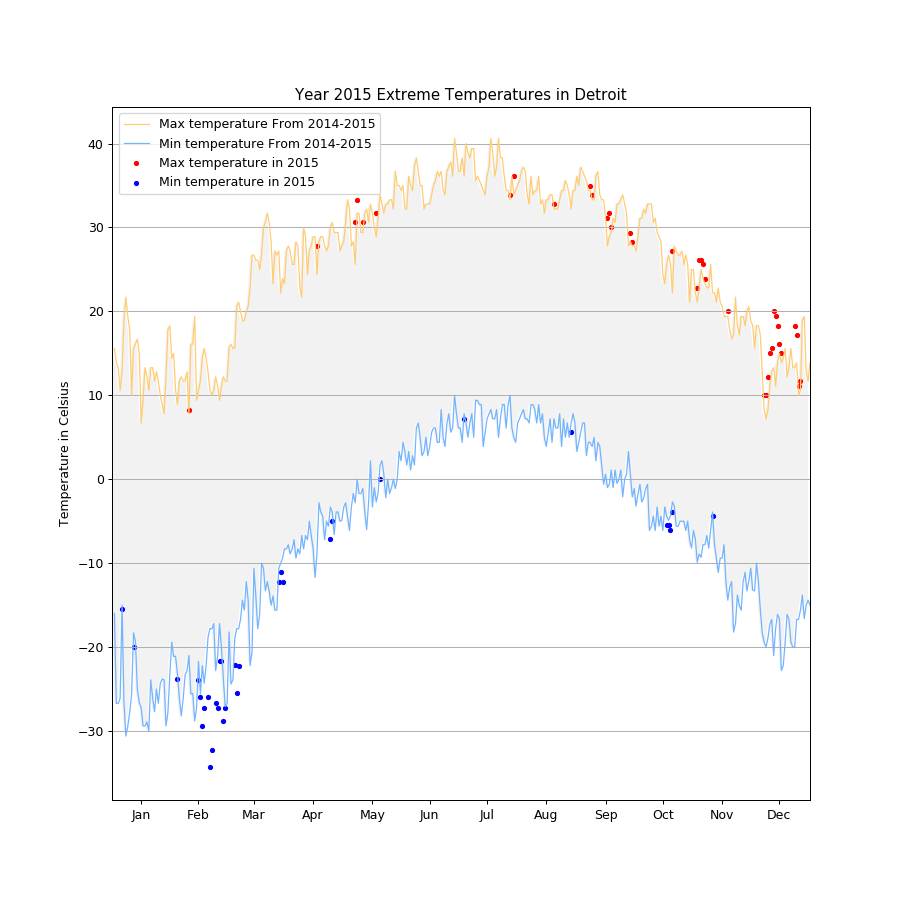

In [21]:
plt.figure(figsize=(10,10))

#Add max line graph
plt.plot(max_temp.day_of_year, max_temp.Data_Value, color='#ffcc73', linewidth=1, label="Max temperature From 2014-2015")

#Add min line graph
plt.plot(min_temp.day_of_year, min_temp.Data_Value, color='#73b4ff', linewidth=1, label="Min temperature From 2014-2015")

#Fill area between the line graphs
plt.gca().fill_between(range(len(max_temp.day_of_year)), 
                       min_temp.Data_Value, max_temp.Data_Value, 
                       facecolor='grey', 
                       alpha=0.1)

#Add 2015 scatterplot
plt.scatter(exceed_max["day_of_year"], exceed_max["Data_Value_2015"], label='Max temperature in 2015', s= 10, color='red')
plt.scatter(exceed_min["day_of_year"], exceed_min["Data_Value_2015"], label='Min temperature in 2015', s= 10, color='blue')

#Add labels
ax = plt.gca()
ax.set_xlim(left=0, right=365)
ax.set_ylabel('Temperature in Celsius')
ax.set_title('Year 2015 Extreme Temperatures in Detroit')
ax.set_xticks([15, 45, 74, 105, 136, 166, 196, 227, 258, 288, 319, 349])
ax.set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
ax.yaxis.grid()

plt.legend(loc='upper left')
